# 데이터 준비


In [1]:
import pymysql
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from pandas import DataFrame
from xgboost import plot_importance

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split


In [2]:
d_QUERY = "select * from distance;"

In [101]:
# 2일간 매 5분
five_QUERY = """
        SELECT * 
        FROM bike 
        WHERE (date BETWEEN DATE_ADD(NOW(), INTERVAL -2 DAY ) AND NOW());
        """

In [4]:
# 3일간 매 30분 - 10분마다 실행 (0, 30) (10, 40) (20, 50) 

thirty_QUERY = """
        SELECT * 
        FROM bike 
        WHERE (date BETWEEN DATE_SUB(NOW(), INTERVAL 3 DAY ) AND NOW())
        AND minute(date) in (round(minute(NOW()), -1),round(minute(DATE_ADD(NOW(), INTERVAL 30 MINUTE)), -1));
        """

In [5]:
# 일주일 1시간 단위 - 10분마다 실행 
one_QUERY = """
        SELECT * 
        FROM bike 
        WHERE (date BETWEEN DATE_SUB(NOW(), INTERVAL 7 DAY ) AND NOW())
        AND minute(date) = round(minute(NOW()), -1);
        """

In [6]:
# 일주일 2시간 단위 - 10분마다 실행
two_QUERY = """
        set list = if(hour(NOW())%2 = 0, (0,2,4,6,8,10,12,14,16,18,20,22), (1,3,5,7,9,11,13,15,17,19,21,23))

        SELECT * 
        FROM bike 
        WHERE (date BETWEEN DATE_SUB(NOW(), INTERVAL 14 DAY ) AND NOW())
        AND  hour(date) in list
        AND minute(date) = round(minute(NOW()), -1);

        """

In [7]:
# 서버시간 맞추기 위해서
q = "select @@global.time_zone, @@session.time_zone,@@system_time_zone;"
q1 = "SET GLOBAL time_zone='+09:00';"
q2 = "SET time_zone='+09:00';"
q3 = "select now()"

In [128]:
conn = pymysql.connect(
    host='172.18.0.2', 
    port=3306,
    user='root',
    passwd='insight2022',
    db='insight',
    charset='utf8',
    autocommit=False
)

cursor = conn.cursor(cursor=pymysql.cursors.DictCursor)


cursor.execute(thirty_QUERY)
bike_data = cursor.fetchall() # list of dictionary
bike_df = pd.DataFrame.from_dict(bike_data)

cursor.execute(d_QUERY)
distance_data = cursor.fetchall() # list of dictionary
distance_df = pd.DataFrame.from_dict(distance_data)

cursor.close()
conn.close()


In [129]:
bike_df['date']=bike_df['date'].dt.strftime('%Y-%m-%d %H-%M')
bike_df = bike_df.drop_duplicates(['station_id', 'date'])
bike_df.head()

,id,rack_tot_cnt,parking_bike_tot_cnt,shared,station_id,date
0,5865038,15,12,80,ST-4,2022-05-17 19-40
1,5865039,14,7,50,ST-5,2022-05-17 19-40
2,5865040,13,1,8,ST-6,2022-05-17 19-40
3,5865041,5,1,20,ST-7,2022-05-17 19-40
4,5865042,12,5,42,ST-8,2022-05-17 19-40


In [130]:
data = bike_df.pivot(index='station_id', columns='date', values='parking_bike_tot_cnt')
data.head()

date,2022-05-17 19-40,2022-05-17 20-10,2022-05-17 20-40,2022-05-17 21-10,2022-05-17 21-40,2022-05-17 22-10,2022-05-17 22-40,2022-05-17 23-10,2022-05-17 23-40,2022-05-18 00-10,...,2022-05-20 14-40,2022-05-20 15-10,2022-05-20 15-40,2022-05-20 16-10,2022-05-20 16-40,2022-05-20 17-10,2022-05-20 17-40,2022-05-20 18-10,2022-05-20 18-40,2022-05-20 19-10
station_id,,,,,,,,,,,,,,,,,,,,,
ST-10,1,2,1,0,2,0,0,1,0,0,...,27,28,29,31,23,13,9,3,0,0
ST-1000,31,31,33,37,40,43,46,51,57,62,...,12,14,14,11,16,16,16,16,25,32
ST-1002,4,3,7,6,4,2,0,0,0,0,...,24,23,23,21,34,33,24,16,17,17
ST-1003,7,9,8,11,14,15,19,19,18,22,...,9,14,9,8,7,7,4,1,5,9
ST-1004,14,17,17,15,18,19,19,19,19,19,...,28,28,29,27,31,30,28,30,29,27


In [105]:
d = distance_df[distance_df.columns[[0,4,5,6,7,8,9]]]

data = pd.merge(d,data, on='station_id', how='inner').set_index('station_id')
data.head()

,mt1,cs2,sc4,ac5,sw8,ct1,2022-05-18 19-10,2022-05-18 19-15,2022-05-18 19-20,2022-05-18 19-25,...,2022-05-20 18-20,2022-05-20 18-25,2022-05-20 18-30,2022-05-20 18-35,2022-05-20 18-40,2022-05-20 18-45,2022-05-20 18-50,2022-05-20 18-55,2022-05-20 19-00,2022-05-20 19-05
station_id,,,,,,,,,,,,,,,,,,,,,
ST-10,497,67,611,108,483,38,0,0,3,4,...,1,0,1,0,0,0,0,0,0,0
ST-1000,320,137,103,120,242,304,25,26,28,28,...,22,20,21,22,25,28,28,28,29,32
ST-1002,79,129,428,191,605,125,1,0,1,0,...,12,14,15,15,17,17,17,17,16,15
ST-1003,32,115,177,46,1099,270,17,18,18,18,...,0,2,2,5,5,6,4,4,5,6
ST-1004,255,103,88,180,1945,760,19,19,19,19,...,30,31,31,31,29,27,27,27,27,27


In [106]:
# 중복 데이터 record 확인
data[data.duplicated(keep = False)]

,mt1,cs2,sc4,ac5,sw8,ct1,2022-05-18 19-10,2022-05-18 19-15,2022-05-18 19-20,2022-05-18 19-25,...,2022-05-20 18-20,2022-05-20 18-25,2022-05-20 18-30,2022-05-20 18-35,2022-05-20 18-40,2022-05-20 18-45,2022-05-20 18-50,2022-05-20 18-55,2022-05-20 19-00,2022-05-20 19-05
station_id,,,,,,,,,,,,,,,,,,,,,


## X, Y 데이터 분리하기


In [107]:
data.isnull().sum()
data = data.fillna(0)

In [108]:
X = data.drop(data.columns[-1], axis=1)
y = data[data.columns[-1]]

In [109]:
X.head()

,mt1,cs2,sc4,ac5,sw8,ct1,2022-05-18 19-10,2022-05-18 19-15,2022-05-18 19-20,2022-05-18 19-25,...,2022-05-20 18-15,2022-05-20 18-20,2022-05-20 18-25,2022-05-20 18-30,2022-05-20 18-35,2022-05-20 18-40,2022-05-20 18-45,2022-05-20 18-50,2022-05-20 18-55,2022-05-20 19-00
station_id,,,,,,,,,,,,,,,,,,,,,
ST-10,497,67,611,108,483,38,0,0,3,4,...,2,1,0,1,0,0,0,0,0,0
ST-1000,320,137,103,120,242,304,25,26,28,28,...,18,22,20,21,22,25,28,28,28,29
ST-1002,79,129,428,191,605,125,1,0,1,0,...,12,12,14,15,15,17,17,17,17,16
ST-1003,32,115,177,46,1099,270,17,18,18,18,...,1,0,2,2,5,5,6,4,4,5
ST-1004,255,103,88,180,1945,760,19,19,19,19,...,30,30,31,31,31,29,27,27,27,27


In [110]:
# 라벨 값의 비율 확인 
y.value_counts()

0     503
1     301
2     212
3     175
4     144
     ... 
84      1
82      1
63      1
52      1
77      1
Name: 2022-05-20 19-05, Length: 74, dtype: int64

## train / test 분리


In [111]:
# train, test 7:3 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [112]:
print(X_test.shape)
print("Train ratio of X:", X_train.shape[0] / X.shape[0])
print("Test ratio of X:", X_test.shape[0] / X.shape[0])

(775, 581)
Train ratio of X: 0.6997287872917474
Test ratio of X: 0.30027121270825263


In [113]:
X_train.head()

,mt1,cs2,sc4,ac5,sw8,ct1,2022-05-18 19-10,2022-05-18 19-15,2022-05-18 19-20,2022-05-18 19-25,...,2022-05-20 18-15,2022-05-20 18-20,2022-05-20 18-25,2022-05-20 18-30,2022-05-20 18-35,2022-05-20 18-40,2022-05-20 18-45,2022-05-20 18-50,2022-05-20 18-55,2022-05-20 19-00
0,571,32,483,112,1503,388,3,3,3,3,...,0,1,1,1,1,1,1,2,2,2
1,236,19,133,58,390,205,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
2,1180,39,163,61,71,43,0,0,2,1,...,1,0,0,0,1,0,0,0,0,1
3,452,80,91,241,109,141,5,4,3,4,...,3,3,3,4,5,8,7,7,7,8
4,701,53,256,16,720,1105,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2


In [114]:
needScale = X_train.columns.to_list()# scale 이 필요한 컬럼들

MMS = MinMaxScaler()

for column in needScale:
    X_train[column] = MMS.fit_transform(X_train[column].to_numpy().reshape(-1, 1))
    X_test[column] = MMS.transform(X_test[column].to_numpy().reshape(-1, 1))

In [115]:
X_train.head()

,mt1,cs2,sc4,ac5,sw8,ct1,2022-05-18 19-10,2022-05-18 19-15,2022-05-18 19-20,2022-05-18 19-25,...,2022-05-20 18-15,2022-05-20 18-20,2022-05-20 18-25,2022-05-20 18-30,2022-05-20 18-35,2022-05-20 18-40,2022-05-20 18-45,2022-05-20 18-50,2022-05-20 18-55,2022-05-20 19-00
0,0.252228,0.029412,0.187398,0.053340,0.475948,0.226184,0.035714,0.035294,0.034483,0.034884,...,0.000000,0.008333,0.00813,0.008065,0.007937,0.008130,0.008065,0.016393,0.016,0.015873
1,0.102941,0.015251,0.044190,0.027391,0.121376,0.119229,0.035714,0.035294,0.034483,0.034884,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
2,0.523619,0.037037,0.056465,0.028832,0.019752,0.024547,0.000000,0.000000,0.022989,0.011628,...,0.008264,0.000000,0.00000,0.000000,0.007937,0.000000,0.000000,0.000000,0.000,0.007937
3,0.199198,0.081699,0.027005,0.115329,0.031857,0.081823,0.059524,0.047059,0.034483,0.046512,...,0.024793,0.025000,0.02439,0.032258,0.039683,0.065041,0.056452,0.057377,0.056,0.063492
4,0.310160,0.052288,0.094517,0.007208,0.226505,0.645237,0.011905,0.011765,0.011494,0.011628,...,0.008264,0.008333,0.00813,0.008065,0.007937,0.008130,0.008065,0.008197,0.008,0.015873


### DACON - XGboost



In [116]:
reg = xgb.XGBRegressor(max_depth = 4, n_estimators = 100)
reg.fit(X_train,y_train)


score = reg.score(X_train, y_train)   
print("Training score: ", score) 

pred_score = reg.score(X_test, y_test)   
print("Testing score: ", pred_score) 
 
# - cross validataion 
scores = cross_val_score(reg, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())


#RMSE는 모델의 예측 값고 실제 값의 차이를 하나의 숫자로 표현


kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(reg, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
 
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

# 숫자가 적을 수록 예측값과 실제 값의 차이가 적은 것을 의미함.
mae = mean_absolute_error(y_test, y_pred)
print("mae: %.2f" % mae)

Training score:  0.99936920020599
Testing score:  0.9800916792173063
Mean cross-validation score: 0.98
K-fold CV average score: 0.98
MSE: 2.74
RMSE: 1.65
mae: 0.92


In [117]:
# 5분 뒤에 값을 예측(test set)한거임
yy_pred = y_pred.round()

for i in range(100, 200, 20):
    print(str(yy_pred[i]),'\t' ,str(y_test[i]), '\n')

25.0 	 24 

2.0 	 6 

0.0 	 0 

2.0 	 2 

82.0 	 75 



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

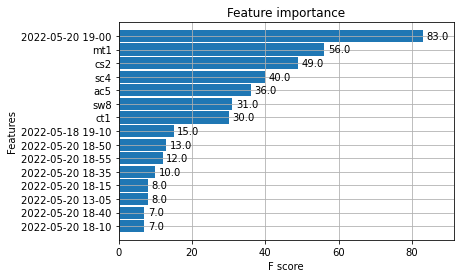

In [118]:
plot_importance(reg, height=0.9, max_num_features=15)

In [119]:
# 열의 개수를 맞추기 위해서 제일 오래된 값 하나 제거
test = data.drop(data.columns[6], axis=1)

needScale = test.columns.to_list()# scale 이 필요한 컬럼들

for column in needScale:
    test[column] = MMS.transform(test[column].to_numpy().reshape(-1, 1))

y_pred = reg.predict(test)
yy_pred = y_pred.round()

# 5분 뒤 값 예측
yy_pred

array([ 0., 34., 15., ...,  3.,  5., 17.], dtype=float32)

In [124]:
five_QUERY = """
        SELECT * 
        FROM bike 
        WHERE (date BETWEEN DATE_SUB(NOW(), INTERVAL 1 DAY ) AND NOW())
        AND minute(date) in (round(minute(NOW()), -1),round(minute(DATE_ADD(NOW(), INTERVAL 30 MINUTE)), -1));
        """


conn = pymysql.connect(
    host='172.18.0.2', 
    port=3306,
    user='root',
    passwd='insight2022',
    db='insight',
    charset='utf8',
    autocommit=False
)

cursor = conn.cursor(cursor=pymysql.cursors.DictCursor)


cursor.execute(five_QUERY)
test_data = cursor.fetchall() # list of dictionary
test_df = pd.DataFrame.from_dict(test_data)

cursor.close()
conn.close()

test_df[2500:2800]

,id,rack_tot_cnt,parking_bike_tot_cnt,shared,station_id,date
2500,8079455,8,0,0,ST-2795,2022-05-20 19:05:02
2501,8079456,10,20,200,ST-2846,2022-05-20 19:05:02
2502,8079457,8,29,363,ST-2860,2022-05-20 19:05:02
2503,8079458,5,2,40,ST-2881,2022-05-20 19:05:02
2504,8079459,8,12,150,ST-2921,2022-05-20 19:05:02
...,...,...,...,...,...,...
2795,8079750,13,0,0,ST-173,2022-05-20 19:10:02
2796,8079751,8,0,0,ST-174,2022-05-20 19:10:02
2797,8079752,10,7,70,ST-175,2022-05-20 19:10:02
2798,8079753,10,1,10,ST-176,2022-05-20 19:10:02


In [125]:
test_df.tail()

,id,rack_tot_cnt,parking_bike_tot_cnt,shared,station_id,date
5157,8082112,16,2,13,ST-3031,2022-05-20 19:10:02
5158,8082113,4,0,0,ST-3015,2022-05-20 19:10:02
5159,8082114,15,7,47,ST-3040,2022-05-20 19:10:02
5160,8082115,7,6,86,ST-3041,2022-05-20 19:10:02
5161,8082116,2,1,50,ST-1747,2022-05-20 19:10:02


In [127]:
# 결과 확인을 위한 부분
test_df = test_df.pivot(index='station_id', columns='date', values='parking_bike_tot_cnt')
a = test_df[test_df.columns[-1]].to_list()

mse = mean_squared_error(yy_pred, a)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

# 숫자가 적을 수록 예측값과 실제 값의 차이가 적은 것을 의미함.
mae = mean_absolute_error(yy_pred, a)
print("mae: %.2f" % mae)

for i in range(100, 400, 20):
    print(str(yy_pred[i]),'\t', a[i])

MSE: 1.92
RMSE: 1.38
mae: 0.76
17.0 	 17
1.0 	 1
2.0 	 2
28.0 	 26
4.0 	 5
9.0 	 12
0.0 	 0
11.0 	 13
15.0 	 15
-0.0 	 0
8.0 	 7
0.0 	 0
4.0 	 4
1.0 	 1
10.0 	 11
